<a href="https://colab.research.google.com/github/prantoran/ai-prac/blob/master/Contrastic_PCA_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Contrastive PCA**: Read [this paper](https://www.nature.com/articles/s41467-018-04608-8)

- Implementation of contrastive PCA in Python.

* The method to a synthetic dataset and compared with standard PCA.


Constrastive PCA will work for datasets which are an overlap of two distinct
set of features/patterns in the same dataset and where we want to identify
the presence of features that are not dominant in the dataset.

For example, there is a dataset that consists of a dominant pattern that is
identified by the PCA. However, at the same time, there is a weaker pattern
present in the dataset whose presence is more important to us and this weaker
pattern will not be strongly correlated with the principal components of the
PCA.

The idea of Contrastive PCA is simple at its core. We subtract the signals
associated with the dominant background pattern from the dataset while been
projected at a different space so that the weaker but more important pattern
becomes the prominant signal in the processed dataset.

Contrastice PCA depends on a background dataset to be available for dataset
that is stable, is related to the pattern in our dataset that we want to eliminate and is not chaning with time. Also, the background dataset does not need to be exact as long as they follow the same pattern (in our dataset).

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import cluster # used in find_spectral_alphas()
from numpy import linalg as LA # used in cpca_alphas()
import inspect

In [ ]:
# attributes

standardize = True
n_components = 2
verbose = False
fitted = False

pca_directions = None
bg_eig_vals = None
affinity_matrix = NotImplemented
fg = NotImplemented
bg = NotImplemented
bg_cov = NotImplemented
fg_cov = NotImplemented
active_labels = NotImplemented
colors = NotImplemented
n_fg = NotImplemented
features_d = NotImplemented
n_bg = NotImplemented
features_d_bg = NotImplemented

In [ ]:

def standardize_array(array):
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)
  return np.nan_to_num(standardized_array)

In [ ]:

"""
Computes the covariance matrices of the foreground and background datasets
Parameters
-----------
foreground: array, shape (n_data_points, n_features)
    The dataset in which the interesting directions that we would like to discover are present or enriched
background : array, shape (n_data_points, n_features)
    The dataset in which the interesting directions that we would like to discover are absent or unenriched
preprocess_with_pca_dim: int
    If this parameter is provided (and it is smaller than n_features), then both the foreground and background
    datasets undergo a preliminary round of PCA to reduce their dimension to this number. If it is not provided
    but n_features > 1,000, a preliminary round of PCA is automatically performed to reduce the dimensionality to 1,000.
"""

def fit( foreground, background, preprocess_with_pca_dim=None):
      global pca_directions, bg_eig_vals, affinity_matrix, fg, bg, bg_cov, fg_cov, n_fg, featured_d, n_bg, features_d_bg
      # Housekeeping
      pca_directions = None
      bg_eig_vals = None
      affinity_matrix = None

      # Datasets and dataset sizes
      fg = foreground
      bg = background
      n_fg, features_d = foreground.shape # n_fg = rows, featured_d = cols
      n_bg, features_d_bg = background.shape

      print("foreground.shape:", foreground.shape, "n_fg:", n_fg, "features_d:", features_d)

      if not(features_d==features_d_bg):
          raise ValueError('The dimensionality of the foreground and background datasets must be the same')

      #if the dimension is higher than preprocess_with_pca_dim, then PCA is performed to reduce the dimensionality
      if preprocess_with_pca_dim is None:
          preprocess_with_pca_dim = 1000

      #Center the background and foreground data
      bg = bg - np.mean(bg, axis=0) # mean along the rows, preserving the colums
      if standardize: #Standardize if specified
          bg = standardize_array(bg)

      fg = fg - np.mean(fg, axis=0)
      if standardize: #Standardize if specified
          fg = standardize_array(fg)

      if (features_d < preprocess_with_pca_dim):
          data = np.concatenate((fg, bg),axis=0) # concatenating row-wise
          pca = PCA(n_components = preprocess_with_pca_dim)
          data = pca.fit_transform(data)
          fg = data[:n_fg,:] # first n_fg rows
          bg = data[n_fg:,:]
          features_d = preprocess_with_pca_dim

          if (verbose):
              print("Data dimensionality reduced to "
                  + str(preprocess_with_pca_dim)
                  + ". Percent variation retained: ~"
                  + str(int(100*np.sum(pca.explained_variance_ratio_))) + '%')


      if (verbose):
          print("Data loaded and preprocessed")

      #Calculate the covariance matrices
      bg_cov = bg.T.dot(bg)/(n_bg-1)
      fg_cov = fg.T.dot(fg)/(n_fg-1)

      if (verbose):
          print("Covariance matrices computed")

      global fitted
      fitted = True # used to signal that foreground is ready for transform



In [ ]:
def generate_alphas(max_log_alpha, n_alphas):
  return np.concatenate(([0],np.logspace(-1,max_log_alpha,n_alphas)))

In [ ]:
"""
Returns active and bg dataset projected in the cpca direction, as well as the top c_cpca eigenvalues indices.
If specified, it returns the top_cpca directions
"""
def cpca_alpha(dataset, alpha=1):
  _n_components = n_components
  sigma = fg_cov - alpha*bg_cov
  w, v = LA.eig(sigma)
  eig_idx = np.argpartition(w, -_n_components)[-_n_components:]
  eig_idx = eig_idx[np.argsort(-w[eig_idx])]
  v_top = v[:,eig_idx] # rows: datasets
  reduced_dataset = dataset.dot(v_top) # matrix multiplication
  if (verbose):
    print(inspect.stack()[1].code_context, "v_top.shape:", v_top.shape, "dataset.shape:", dataset.shape, "reduced_dataset.shape:", reduced_dataset.shape)
  reduced_dataset[:,0] = reduced_dataset[:,0]*np.sign(reduced_dataset[0,0])
  reduced_dataset[:,1] = reduced_dataset[:,1]*np.sign(reduced_dataset[0,1])
  return reduced_dataset


"""
This method creates the affinity matrix of subspaces returned by contrastive pca
"""
def create_affinity_matrix(foreeground, max_log_alpha, n_alphas):
  from math import pi
  alphas = generate_alphas(max_log_alpha, n_alphas)
  if (verbose):
    print(inspect.stack()[1].code_context, "alphas: ", alphas)

  subspaces = list()
  k = len(alphas)
  affinity = 0.5*np.identity(k) #it gets doubled
  for alpha in alphas:
    space = cpca_alpha(dataset=foreeground, alpha=alpha)
    q, r = np.linalg.qr(space)
    if (verbose):
      print(inspect.stack()[1].code_context, "alpha:", alpha, "q.shape:", q.shape, "r.shape:", r.shape)
    subspaces.append(q)
  for i in range(k): # 0 -> k-1
    for j in range(i+1,k):
      q0 = subspaces[i]
      q1 = subspaces[j]
      u, s, v = np.linalg.svd(q0.T.dot(q1))
      affinity[i,j] = s[0]*s[1]
  affinity = affinity + affinity.T # saving the mirror image across the leading diagonal
  global affinity_matrix
  affinity_matrix = np.nan_to_num(affinity)


"""
This method performs spectral clustering on the affinity matrix of subspaces
returned by contrastive pca, and returns (`=3) exemplar values of alpha
"""
def find_spectral_alphas( n_alphas, max_log_alpha, n_alphas_to_return):
  create_affinity_matrix(fg, max_log_alpha, n_alphas)
  affinity = affinity_matrix
  if (verbose):
    print(inspect.stack()[1].code_context, "affinity.shape:", affinity.shape)
  spectral = cluster.SpectralClustering(n_clusters=n_alphas_to_return, affinity='precomputed')
  alphas = generate_alphas(max_log_alpha, n_alphas)
  spectral.fit(affinity)
  labels = spectral.labels_
  if (verbose):
    print(inspect.stack()[1].code_context, "labels.shape:", labels.shape)
  best_alphas = list()
  for i in range(n_alphas_to_return):
      idx = np.where(labels==i)[0]
      if not(0 in idx): #because we don't want to include the cluster that includes alpha=0
          affinity_submatrix = affinity[idx][:, idx]
          sum_affinities = np.sum(affinity_submatrix, axis=0)
          exemplar_idx = idx[np.argmax(sum_affinities)]
          if (verbose):
            print(inspect.stack()[1].code_context, "idx:", idx, "idx.shape:", idx.shape, "sum_affinities.shape:", sum_affinities.shape, "affinity_submatrix.shape:", affinity_submatrix.shape, "exemplar_idx.shape:", exemplar_idx.shape, "exemplar_idx:", exemplar_idx)

          best_alphas.append(alphas[exemplar_idx])

  if (verbose):
    print(inspect.stack()[1].code_context, "best_alphas:", best_alphas)

  return np.sort(best_alphas), alphas, affinity[0,:], labels



"""
This function performs contrastive PCA using the alpha technique on the
active and background dataset. It automatically determines n_alphas=4 important values
of alpha up to based to the power of 10^(max_log_alpha=5) on spectral clustering
of the top subspaces identified by cPCA.
The final return value is the data projected into the top (n_components = 2)
subspaces, which can be plotted outside of this function
"""
def automated_cpca(dataset, n_alphas_to_return, n_alphas, max_log_alpha):
  best_alphas, all_alphas, _, _ = find_spectral_alphas(n_alphas, max_log_alpha, n_alphas_to_return)
  best_alphas = np.concatenate(([0], best_alphas)) #one of the alphas is always alpha=0
  data_to_plot = []
  for alpha in best_alphas:
      transformed_dataset = cpca_alpha(dataset=dataset, alpha=alpha)
      data_to_plot.append(transformed_dataset)
  return data_to_plot, best_alphas


"""
This function performs contrastive PCA using the alpha technique on the
active and background dataset. It returns the cPCA-reduced data for all values of alpha specified,
both the active and background, as well as the list of alphas
"""
def all_cpca(dataset, n_alphas, max_log_alpha):
  alphas = generate_alphas(max_log_alpha, n_alphas)
  data_to_plot = []
  for alpha in alphas:
    transformed_dataset = cpca_alpha(dataset=dataset, alpha=alpha)
    data_to_plot.append(transformed_dataset)
  return data_to_plot, alphas

In [ ]:
def gui_callback(dataset, n_alphas_to_return, n_alphas, max_log_alpha):
  try:
      import matplotlib.pyplot as plt
      from matplotlib.gridspec import GridSpec
  except ImportError:
      raise ImportError("Something wrong while loading matplotlib.pyplot! You probably don't have plotting libraries installed.")
  try:
      from ipywidgets import widgets, interact, Layout
      from IPython.display import display
  except ImportError:
      raise ImportError("To use the GUI, you must be running this code in a jupyter notebook that supports ipywidgets")

  transformed_data_auto, alphas_auto = automated_cpca(dataset, n_alphas_to_return, n_alphas, max_log_alpha)
  transformed_data_manual, alphas_manual = all_cpca(dataset, n_alphas, max_log_alpha)
  if (n_fg>1000):
      print("The GUI may be slow to respond with large numbers of data points. Consider using a subset of the original data.")

  """
  Handles the plotting
  """
  def graph_foreground(ax,fg, active_labels, alpha):
      for i, l in enumerate(np.sort(np.unique(active_labels))):
          ax.scatter(fg[np.where(active_labels==l),0],fg[np.where(active_labels==l),1], color=colors[i%len(colors)], alpha=0.6)
      if (alpha==0):
          ax.annotate(r'$\alpha$='+str(np.round(alpha,2))+" (PCA)", (0.05,0.05), xycoords='axes fraction')
      else:
          ax.annotate(r'$\alpha$='+str(np.round(alpha,2)), (0.05,0.05), xycoords='axes fraction')


  """
  This code gets run whenever the widget slider is moved
  """
  def update(value):
      fig = plt.figure(figsize=[10,4])
      gs=GridSpec(2,4)

      for i in range(4):
          ax1=fig.add_subplot(gs[int(i//2),i%2]) # First row, first column
          fg = transformed_data_auto[i]
          graph_foreground(ax1, fg, active_labels, alphas_auto[i])

          ax5=fig.add_subplot(gs[:,2:]) # Second row, span all columns

          alpha_idx = np.abs(alphas_manual-10**value).argmin()
          fg = transformed_data_manual[alpha_idx]
          graph_foreground(ax5, fg, active_labels, alphas_manual[alpha_idx])

      #if len(np.unique(self.active_labels))>1:
          #plt.legend()

      plt.tight_layout()
      plt.show()

  widg = interact(update, value=widgets.FloatSlider(description=r'\(\log_{10}{\alpha} \)', min=-1, max=3, step=4/40, continuous_update=False, layout=Layout(width='80%')))

  return


In [ ]:
def plot_callback(alpha_selection, dataset, n_alphas_to_return, n_alphas, max_log_alpha, alpha_value):
  try:
    import matplotlib.pyplot as plt
  except ImportError:
    raise ImportError("Something wrong while loading matplotlib.pyplot! You probably don't have plotting libraries installed.")
  if (alpha_selection=='auto'):
    transformed_data, best_alphas = automated_cpca(dataset, n_alphas_to_return, n_alphas, max_log_alpha)
    plt.figure(figsize=[14,3])
    for j, fg in enumerate(transformed_data):
        plt.subplot(1,4,j+1)
        for i, l in enumerate(np.sort(np.unique(active_labels))):
            idx = np.where(active_labels==l)
            plt.scatter(fg[idx,0],fg[idx,1], color=colors[i%len(colors)], alpha=0.6, label='Class '+str(i))
        plt.title('Alpha='+str(np.round(best_alphas[j],2)))
    if len(np.unique(active_labels))>1:
        plt.legend()
    plt.show()
  elif (alpha_selection=='manual'):
    fg = cpca_alpha(dataset, alpha_value)
    plt.figure(figsize=[6,6])
    for i, l in enumerate(np.sort(np.unique(active_labels))):
        idx = np.where(active_labels==l)
        plt.scatter(fg[idx,0],fg[idx,1], color=colors[i%len(colors)], alpha=0.6, label='Class '+str(i))
    plt.title('Alpha=' + str(alpha_value))
    plt.legend()
    plt.show()

  return

In [ ]:

def transform(
    dataset,
    alpha_selection='auto',
    n_alphas=40,
    max_log_alpha=3,
    n_alphas_to_return=4,
    plot_callback = None,
    gui_callback = None,
    _active_labels = None,
    _colors=None,
    legend=None,
    alpha_value=None,
    return_alphas=False):

  # validations
  if (fitted==False):
      raise ValueError("This model has not been fit to a foreground/background dataset yet. Please run the fit() or fit_transform() functions first.")
  if not(alpha_selection=='auto' or alpha_selection=='manual' or alpha_selection=='all'):
      raise ValueError("Invalid argument for parameter alpha_selection: must be 'auto' or 'manual' or 'all'")
  if (alpha_selection=='all' and plot_callback==True):
      raise ValueError('The plot_callback cannot be used if alpha_selection is set to "all"')
  if ((alpha_selection=='all' or alpha_selection=='manual') and gui_callback==True):
      raise ValueError('The gui_callback cannot be used if alpha_selection is set to "all" or "manual"')
  if ((gui_callback==True or plot_callback==True) and not(n_components==2)):
      raise ValueError('The gui and plot callbacks cannot be used if the number of components is not 2')
  if (not(alpha_value) and alpha_selection=='manual'):
      raise ValueError('The the alpha_selection parameter is set to "manual", the alpha_value parameter must be provided')

  # we can't be plot or gui with non-2 components
  # Handle the plotting variables

  if (plot_callback or gui_callback):
    if _active_labels is None:
      _active_labels = np.ones(dataset.shape[0])
    global active_labels, colors
    active_labels = _active_labels
    if _colors is None:
      _colors = ['k','r','b','g','c']

    colors = _colors

    if gui_callback:
      gui_callback(dataset, n_alphas_to_return, n_alphas, max_log_alpha)
    elif plot_callback:
      plot_callback(alpha_selection, dataset, n_alphas_to_return, n_alphas, max_log_alpha, alpha_value)

  else:
    if (alpha_selection=='auto'):
      transformed_data, best_alphas = automated_cpca(dataset, n_alphas_to_return, n_alphas, max_log_alpha)
      alpha_values = best_alphas
    elif (alpha_selection=='all'):
      transformed_data, all_alphas = all_cpca(dataset, n_alphas, max_log_alpha)
      alpha_values = all_alphas
    else:
      transformed_data = cpca_alpha(dataset, alpha_value)
      alpha_values = alpha_value

    if return_alphas:
        return transformed_data, alpha_values
    else:
        return transformed_data


In [ ]:
"""
  Finds the covariance matrices of the foreground and background datasets,
  and then transforms the foreground dataset based on the principal contrastive components
  Parameters: see fit() and transform() for parameter description
"""
def fit_transform(
    foreground,
    background,
    plot=None,
    gui=None,
    alpha_selection='auto',
    n_alphas=40,
     max_log_alpha=3,
    n_alphas_to_return=4,
    active_labels = None,
    colors=None,
    legend=None,
    alpha_value=None,
    return_alphas=False):

  fit(foreground, background)

  return transform(
      dataset=fg,
      alpha_selection=alpha_selection,
      n_alphas=n_alphas,
      max_log_alpha=max_log_alpha,
      n_alphas_to_return=n_alphas_to_return,
      plot_callback=plot,
      gui_callback=gui,
      _active_labels=active_labels,
      _colors=colors,
      legend=legend,
      alpha_value=alpha_value,
      return_alphas=return_alphas)

## Synthetic Dataset

Create a synthetic dataset consisting on 3 features
The Foreground and Background have similarities with 2 of the features while varying on the third feature.

In [ ]:
N = 400; D = 1000; gap=3
# In B, all the data pts are from the same distribution, which has different variances in three subspaces.
B = np.zeros((N, D))
B[:,0:10] = np.random.normal(0,10,(N,10))
B[:,10:20] = np.random.normal(0,3,(N,10))
B[:,20:30] = np.random.normal(0,1,(N,10))


# In A there are four clusters.
A = np.zeros((N, D))
A[:,0:10] = np.random.normal(0,10,(N,10))
A[:,10:20] = np.random.normal(0,3,(N,10))
# group 1
A[0:200, 20:30] = np.random.normal(0,1,(200,10))
# group 2
A[200:400, 20:30] = np.random.normal(gap,1,(200,10))
A_labels = [0]*200+[1]*200

print(A.shape)
print(B.shape)

(400, 1000)
(400, 1000)


## Applying Contrastice PCA on synthetic dataset

foreground.shape: (400, 1000) n_fg: 400 features_d: 1000


<ipython-input-7-e48a98acd547>:2: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


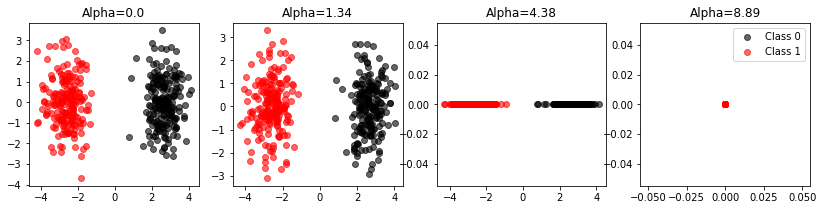

In [ ]:

fit_transform(A, B, plot=plot_callback, active_labels=A_labels)
# fit_transform(A, B, plot=None, active_labels=A_labels)


## Applying PCA on synthetic dataset for comparison

In the scatter plot showing the dataset transformed by PCA, we can see that the two clusters are mixed together since there is overlap in 2 of the 3 features of the clusters and PCA's principal components preferred the directions of the 2 common features of the clusters.

Constrastive PCA is helpful in this situation since the common features are removed with the help of a background dataset.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = A
X_new = pca.fit_transform(X_pca)


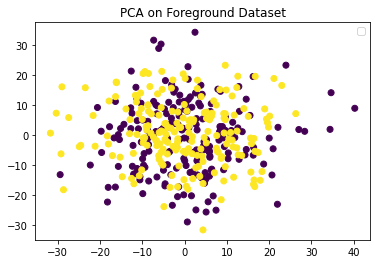

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(X_new[:, 0], X_new[:, 1], c = A_labels)

plt.title('PCA on Foreground Dataset')
plt.legend()

plt.show()

# 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [ ]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?

[Please put your write up here]